<a href="https://colab.research.google.com/github/sashank1326/ML_Practice/blob/main/Titanic_Ml_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/titanic_train.csv")

df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# **Features**

In [ ]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
df.dropna(axis = 1,thresh= 0.7*len(df),inplace = True)

# Filling the null values(numeric column) with median

numerical_cols = df.select_dtypes(include = ['int64','float64']).columns
categorical_cols = df.select_dtypes(include = ['int64','float64']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
X = df.drop("Survived", axis=1)
y = df["Survived"]


# 2. Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (712, 10)
Test shape: (179, 10)


In [ ]:
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]

print(constant_features)

[]


In [ ]:
# 4. Quasi-constant features (based on threshold)
quasi_constant_features = []
threshold = 0.95

for col in X_train.columns:
    freq = X_train[col].value_counts(normalize=True).values[0]
    if freq >= threshold:
        quasi_constant_features.append(col)

print("Quasi-constant features:", quasi_constant_features)

X_train.drop(columns=quasi_constant_features, inplace=True)
X_test.drop(columns=quasi_constant_features, inplace=True)

Quasi-constant features: []


In [ ]:
duplicated_features = []
cols = X_train.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if X_train[cols[i]].equals(X_train[cols[j]]):
            duplicated_features.append(cols[j])

print(duplicated_features)

[]


In [ ]:
numeric_X_train = X_train.select_dtypes(include=['number'])

corr_matrix = numeric_X_train.corr()
corr_threshold = 0.98
corr_pairs = set()

# Find highly correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            corr_pairs.add(corr_matrix.columns[i])

print("Highly Correlated Features:", corr_pairs)

Highly Correlated Features: set()


[]

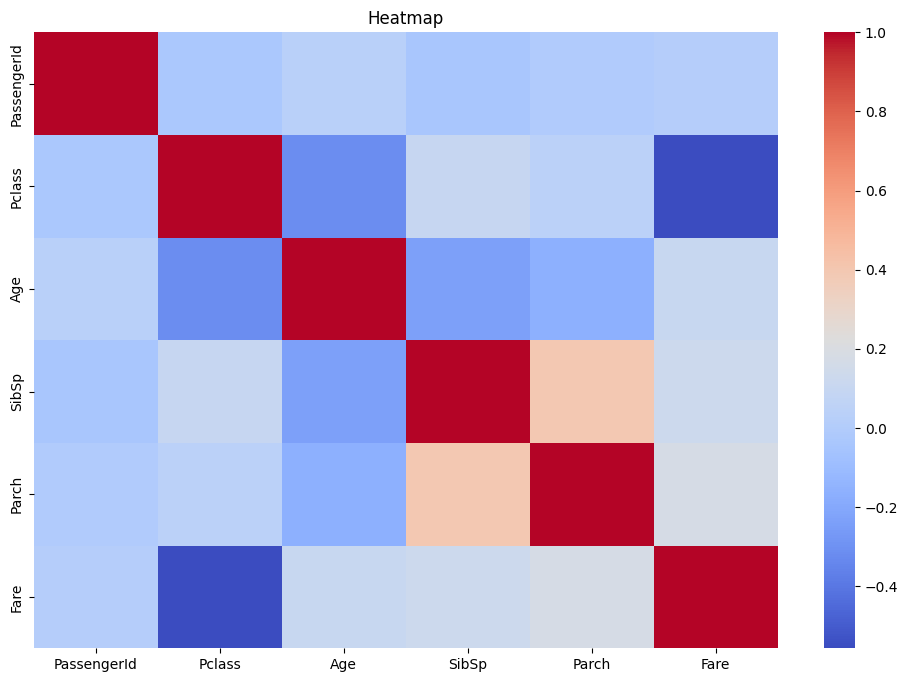

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix,annot=False,cmap = "coolwarm")
plt.title("Heatmap")
plt.plot()

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Select numeric features
numeric_X_train = X_train.select_dtypes(include=['number'])

# Compute MI scores
mi_scores = mutual_info_regression(numeric_X_train, y_train, discrete_features=False)

# Create DataFrame of results
mi_df = pd.DataFrame({
    "Features": numeric_X_train.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)

# Select features with MI score < 0.01
# print(mi_df)
low_imp = mi_df[mi_df["MI Score"] < 0.01]["Features"].tolist()

print("Low Importance Features:", low_imp)

# Drop low importance features
X_train = X_train.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

Low Importance Features: ['PassengerId']


In [ ]:
cat_features = X_train.select_dtypes(include=['object', 'category']).copy()

# Encode categorical features numerically
label_enc = LabelEncoder()
for col in cat_features.columns:
    cat_features[col] = cat_features[col].astype(str)  # Handle NaN as string
    cat_features[col] = label_enc.fit_transform(cat_features[col])

# Apply Chi-square test
chi_scores, p_values_chi = chi2(cat_features, y_train)

chi_df = pd.DataFrame({
    'Feature': cat_features.columns,
    'Chi2_Score': chi_scores,
    'P_Value': p_values_chi
}).sort_values(by='Chi2_Score', ascending=False)

print("Chi-Square Test Results (Categorical Features):")
print(chi_df)

Chi-Square Test Results (Categorical Features):
    Feature   Chi2_Score       P_Value
2    Ticket  2058.884368  0.000000e+00
0      Name   360.798816  1.886447e-80
1       Sex    76.301994  2.434380e-18
3  Embarked    10.099757  1.482889e-03


In [ ]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).copy()

# Scale features (optional for ANOVA stability)
scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(num_features)

# Apply ANOVA F-test for classification
f_scores, p_values_anova = f_classif(num_scaled, y_train)

anova_df = pd.DataFrame({
    'Feature': num_features.columns,
    'F_Score': f_scores,
    'P_Value': p_values_anova
}).sort_values(by='F_Score', ascending=False)

print("\nANOVA Test Results (Numeric Features):")
print(anova_df)


ANOVA Test Results (Numeric Features):
  Feature    F_Score       P_Value
0  Pclass  97.835853  1.064770e-21
4    Fare  58.314907  7.230704e-14
3   Parch   5.066904  2.469201e-02
1     Age   4.142223  4.219711e-02
2   SibSp   0.484537  4.866020e-01


In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

X = df.drop(columns=['TARGET']).select_dtypes(include='number')
y = df['TARGET']   # binary target (0/1)

roc_auc_scores = {}

for feature in X.columns:
    roc_auc_scores[feature] = roc_auc_score(y, X[feature])

roc_auc_series = pd.Series(roc_auc_scores).sort_values(ascending=False)
print(roc_auc_series)


var15                  0.698640
var36                  0.613575
ind_var8_0             0.521329
num_var8_0             0.521328
num_meses_var8_ult3    0.512840
                         ...   
saldo_var5             0.325784
saldo_var42            0.323957
num_var30              0.323573
num_meses_var5_ult3    0.311415
saldo_var30            0.309171
Length: 370, dtype: float64


# **Wrraper**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import numpy as np

In [ ]:
df = df.drop(["PassengerId", "Name", "Ticket"], axis=1)
df = pd.get_dummies(df, drop_first=True)

In [ ]:
df.head()
X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
sfs_forward = SFS(RandomForestClassifier(),
                  k_features=5,
                  forward=True,
                  floating=False,
                  verbose=2,
                  scoring='accuracy',
                  cv=3)

sfs_forward = sfs_forward.fit(X_train, y_train)

print("Forward Selection Features:", X_train.columns[list(sfs_forward.k_feature_idx_)])

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.1s finished

[2025-08-23 08:13:12] Features: 1/5 -- score: 0.7893368317791252[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.0s finished

[2025-08-23 08:13:16] Features: 2/5 -- score: 0.7963514519731945[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.4s finished

[2025-08-23 08:13:20] Features: 3/5 -- score: 0.8005885898663263[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished

[2025-08-23 08:13:23] Features: 4/5 -- score: 0.8033897103145056

Forward Selection Features: Index(['Pclass', 'Age', 'SibSp', 'Sex_male', 'Embarked_S'], dtype='object')


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s finished

[2025-08-23 08:13:28] Features: 5/5 -- score: 0.8216383599853444

In [ ]:
sfs_backward = SFS(RandomForestClassifier(),
                   k_features=5,
                   forward=False,
                   floating=False,
                   verbose=2,
                   scoring='accuracy',
                   cv=3)

sfs_backward = sfs_backward.fit(np.array(X_train), y_train)
print("Backward Selection Features:", X_train.columns[list(sfs_backward.k_feature_idx_)])

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.4s finished

[2025-08-21 14:46:36] Features: 7/5 -- score: 0.8104043305085747[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.8s finished

[2025-08-21 14:46:45] Features: 6/5 -- score: 0.8118048907326644

Backward Selection Features: Index(['Pclass', 'Age', 'Parch', 'Fare', 'Sex_male'], dtype='object')


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.7s finished

[2025-08-21 14:46:55] Features: 5/5 -- score: 0.8103925114349537

In [ ]:
lr = LogisticRegression(max_iter=500)

efs = EFS(estimator=lr,
          min_features=1,
          max_features=4,
          scoring='accuracy',
          cv=5)

efs = efs.fit(X_train, y_train)
print("Best Accuracy Score (EFS):", efs.best_score_)
print("Best subset indices (EFS):", efs.best_idx_)
print("Best subset names (EFS):", efs.best_feature_names_)

Features: 162/162

Best Accuracy Score (EFS): 0.7991923569388358
Best subset indices (EFS): (0, 1, 5, 7)
Best subset names (EFS): ('Pclass', 'Age', 'Sex_male', 'Embarked_S')


In [ ]:
model = LogisticRegression(max_iter=500)
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

print("RFE Selected Features:", X_train.columns[rfe.support_].tolist())
print("RFE Feature Ranking:", rfe.ranking_)

RFE Selected Features: ['Pclass', 'SibSp', 'Sex_male', 'Embarked_Q', 'Embarked_S']
RFE Feature Ranking: [1 3 1 2 4 1 1 1]


In [ ]:
# Step 1: Create the model
clf = RandomForestClassifier(n_jobs=4, random_state=42)

# Step 2: Initialize RFECV
rfecv = RFECV(estimator=clf,
              step=1,
              cv=StratifiedKFold(3),
              scoring='precision',
              n_jobs=4,
              verbose=2)

# Step 3: Fit the selector
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected feature indices:", rfecv.support_.nonzero()[0])
print("Selected feature names:", X.columns[rfecv.support_].tolist())
X_selected_rs = X.loc[:, rfecv.support_]

# **Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/house_price_train.csv")
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
X = df[['LotArea']]
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)


 # Predicting on the test set
y_pred = model.predict(X_test)

 # Calculating Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test, y_pred)

# Coefficient (m) and Intercept (c)
m = model.coef_[0]
c = model.intercept_


# Create a DataFrame with YrSold, actual, and predicted prices
results_df = X_test.copy()
results_df['Actual_SalePrice'] = y_test.values
results_df['Predicted_SalePrice'] = y_pred

# Print the resulting DataFrame
print(results_df.head(10))  # print first 10 rows

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"Coefficient (m): {m}")
print(f"Intercept (c): {c}")

      LotArea  Actual_SalePrice  Predicted_SalePrice
538     11553            158000        182100.916107
496     12692            430000        184392.903169
597      3922            194201        166745.206476
1005     8385            149900        175726.012672
845     16647            171000        192351.471062
452      9303            204000        177573.285827
148      7500            141000        173945.144762
844     12665            153900        184338.571606
1099    11880            157000        182758.931708
1022     9439             87000        177846.955924
MSE: 5784357862.2811985
MAE: 55338.22533317412
RMSE: 76054.96605929949
R^2: 0.091960080638951
Coefficient (m): 2.0122801246251103
Intercept (c): 158853.04382733992


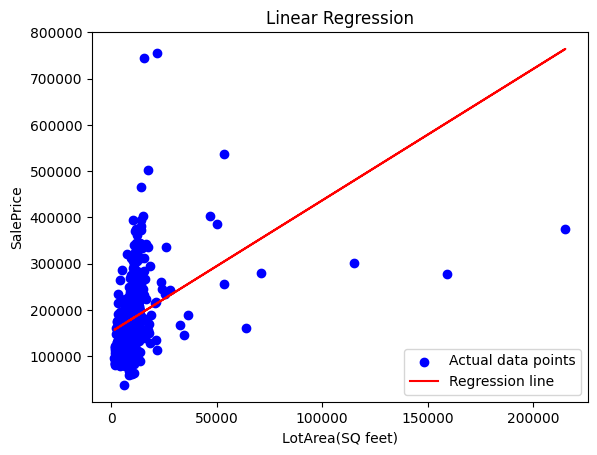

In [ ]:
# Plotting
import matplotlib.pyplot as plt
plt.scatter(X_test, y_test, color='blue', label='Actual data points')
plt.plot(X_test, y_pred, color='red', label='Regression line')
plt.xlabel('LotArea(SQ feet)')
plt.ylabel('SalePrice')
plt.title('Linear Regression')
plt.legend()
plt.show()

# **Multi-Linear-Regression**

In [ ]:
# X = df[[ 'LotArea', 'MSSubClass','YearBuilt','OverallQual','OverallCond']]
X = df.select_dtypes(include ='number').drop('SalePrice',axis = 1)

y = df['SalePrice']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating the Linear Regression model
model = LinearRegression()

# Training the model
model.fit(X_train.fillna(X_train.median()), y_train)
y_pred = model.predict(X_test.fillna(X_train.median()))



# Create a DataFrame with YrSold, actual, and predicted prices
results_df = X_test.copy()
results_df['Actual_SalePrice'] = y_test.values
results_df['Predicted_SalePrice'] = y_pred

mse = mean_squared_error(y_test,y_pred)
mse = mean_absolute_error(y_test,y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

print(results_df)

MSE: 23157.942396393377
MAE: 55338.22533317412
RMSE: 152.1773386427604
R^2: 0.8216880320625121
        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
892    893          20         70.0     8414            6            8   
1105  1106          60         98.0    12256            8            5   
413    414          30         56.0     8960            5            6   
522    523          50         50.0     5000            6            7   
1036  1037          20         89.0    12898            9            5   
...    ...         ...          ...      ...          ...          ...   
331    332          20         70.0     8176            5            6   
323    324          20         49.0     5820            3            8   
650    651          60         65.0     8125            7            6   
439    440          50         67.0    12354            6            8   
798    799          60        104.0    13518            9            5   

      YearBuilt 

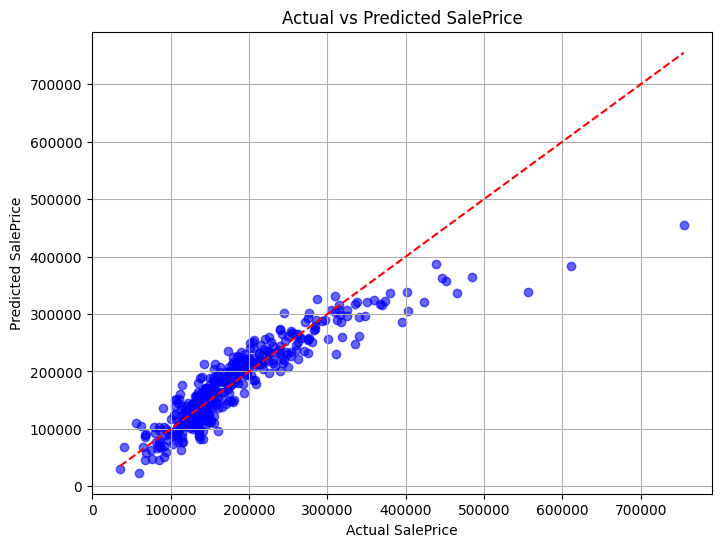

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.grid(True)
plt.show()


# Logistic **Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/titanic_train.csv")
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

X = df[['Sex']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression()
model.fit(X_train, y_train)

 # Predicting on the test set
y_pred = model.predict(X_test)

# Create a DataFrame with YrSold, actual, and predicted prices
results_df = X_test.copy()
results_df['Actual_survival'] = y_test.values
results_df['Predicted_Survival'] = y_pred

# Print the resulting DataFrame
print(results_df.head(20))  # print first 10 rows
accuracy_score = metrics.accuracy_score(y_test, y_pred) * 100
print("ACCURACY",accuracy_score)


     Sex  Actual_survival  Predicted_Survival
630    1                1                   0
852    0                0                   1
620    1                0                   0
195    0                1                   1
818    1                0                   0
524    1                0                   0
390    1                1                   0
316    0                1                   1
272    0                1                   1
453    1                1                   0
323    0                1                   1
535    0                1                   1
484    1                1                   0
456    1                0                   0
41     0                0                   1
423    0                0                   1
563    1                0                   0
804    1                1                   0
29     1                0                   0
586    1                0                   0
ACCURACY 75.0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


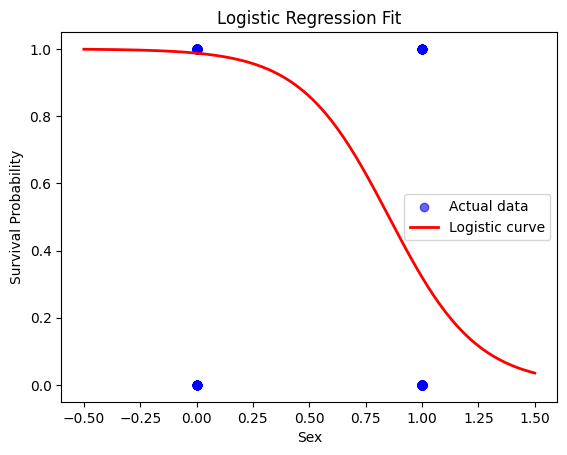

In [ ]:
import numpy as np

# Generate smooth values of Pclass (1 to 3)
X_vals = np.linspace(-0.5, 1.5, 300).reshape(-1,1)

X_range_scaled = scaler.transform(X_range)
y_probs = model.predict_proba(X_range_scaled)[:,1]  # probability of survival = 1

# Plot actual data
plt.scatter(X_test, y_test, color='blue', alpha=0.6, label='Actual data')

# Plot logistic regression curve
plt.plot(X_vals, y_probs, color='red', linewidth=2, label='Logistic curve')

plt.xlabel('Sex')
plt.ylabel('Survival Probability')
plt.title('Logistic Regression Fit')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Encode categorical
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])  # Female=0, Male=1

X = df[['Sex']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the feature (not strictly needed since it's 0/1, but good for sigmoid plotting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Generate values for plotting sigmoid curve
X_range = np.linspace(-0.5, 1.5, 300).reshape(-1, 1)  # smooth values from -0.5 to 1.5
X_range_scaled = scaler.transform(X_range)
y_prob = model.predict_proba(X_range_scaled)[:, 1]

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, color='orange', edgecolors='k', s=70, label="Actual Data")
plt.plot(X_range, y_prob, color='black', linewidth=2, label="Sigmoid Curve")
plt.axhline(0.5, color='gray', linestyle='--')

# Annotate regions
plt.text(-0.4, 0.55, 'Predict Survived', color='green', fontsize=9)
plt.text(-0.4, 0.40, 'Predict Not Survived', color='red', fontsize=9)

plt.title("Logistic Regression - Titanic Survival based on Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Probability of Survival")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [268, 300]

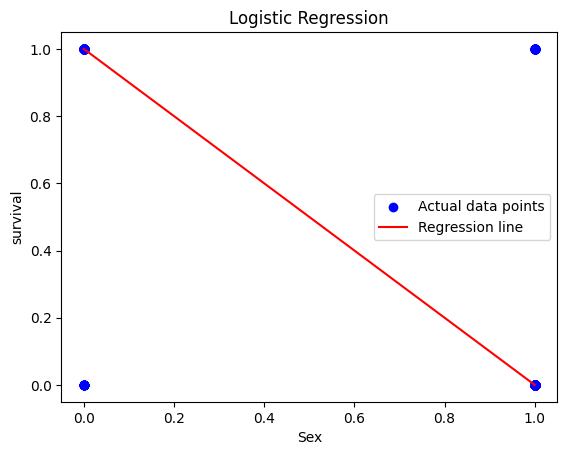

In [ ]:
# Plotting
plt.scatter(X_test, y_test, color='blue', label='Actual data points')
plt.plot(X_test, y_pred, color='red', label='Regression line')
plt.xlabel('Sex')
plt.ylabel('survival')
plt.title('Logistic Regression')
plt.legend()
plt.show()

# **Gradiant Decent**

In [ ]:
#imports
from sklearn import datasets
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/titanic_train.csv")
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

X = df[['Sex']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Keep original X_test for display later
X_test_orig = X_test.copy()

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#SCD schotastic GD
sgd_clf = SGDClassifier(max_iter=200)
sgd_clf.fit(X_train, y_train)
y_pred_sgd = sgd_clf.predict(X_test)
sgd_acc = metrics.accuracy_score(y_test, y_pred_sgd) * 100

print("Accuracy score",sgd_acc)

# Create DataFrame to compare actual vs predicted
results_df = X_test_orig.copy()  # unscaled original features
results_df['Actual_Survival'] = y_test.values
results_df['Predicted_Survival'] = y_pred_sgd

print(results_df.head(20))

79.8507462686567
     Sex  Actual_Survival  Predicted_Survival
178    1                0                   0
15     0                1                   1
597    1                0                   0
759    0                1                   1
142    0                1                   1
60     1                0                   0
362    0                0                   1
223    1                0                   0
379    1                0                   0
757    1                0                   0
260    1                0                   0
95     1                0                   0
332    1                0                   0
283    1                1                   0
600    0                1                   1
590    1                0                   0
387    0                1                   1
71     0                0                   1
342    1                0                   0
643    1                1                   0


In [ ]:
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

X = df[['Sex']]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Approximate Gradient Descent (GD)
gd_clf = SGDClassifier(max_iter=1000, average=True)
gd_clf.fit(X_train, y_train)
y_pred_gd = gd_clf.predict(X_test)
gd_acc = metrics.accuracy_score(y_test, y_pred_gd) * 100
# Print results
print("\nAccuracy Comparison:")
# print(f"SGD Accuracy: {sgd_acc:.2f}%")
print(f"GD (approx) Accuracy: {gd_acc:.2f}%")


Accuracy Comparison:
GD (approx) Accuracy: 80.97%


In [ ]:
# Print results
print("\nAccuracy Comparison:")
print(f"SGD Accuracy: {sgd_acc:.2f}%")
print(f"GD (approx) Accuracy: {gd_acc:.2f}%")


Accuracy Comparison:
SGD Accuracy: 81.34%
GD (approx) Accuracy: 80.97%


# **Regularization**

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/house_price_train.csv")
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# **LR after Regularization(Lasso)**

Mean Squared Error: 7689782687.98441
Model Coefficients: [1.66934621]n
      LotArea  Actual_SalePrice  Predicted_SalePrice
1207     9135            200000        175458.112308
791     11333            146800        179127.335280
490      2665            115000        164657.442321
208     14364            277000        184187.123647
1234     8525            130000        174439.811119
481     11846            374000        179983.709887
578      3604            146000        166224.958413
807     21384            223500        195905.934050
453      9000            210000        175232.750569
158     12552            254900        181162.268312


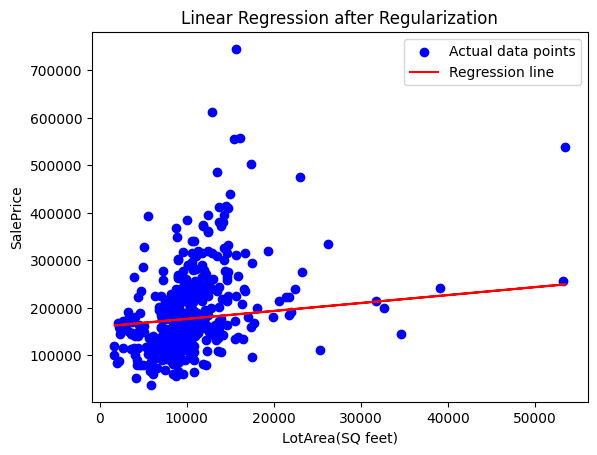

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lasso = Lasso(alpha=100)
# training the model
lasso.fit(X_train, y_train)

# making predictions
y_pred = lasso.predict(X_test)

# evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Model Coefficients: {lasso.coef_}n")

# Create a DataFrame with YrSold, actual, and predicted prices
results_df = X_test.copy()
results_df['Actual_SalePrice'] = y_test.values
results_df['Predicted_SalePrice'] = y_pred

# Print the resulting DataFrame
print(results_df.head(10))

# Plotting
plt.scatter(X_test, y_test, color='blue', label='Actual data points')
plt.plot(X_test, y_pred, color='red', label='Regression line')
plt.xlabel('LotArea(SQ feet)')
plt.ylabel('SalePrice')
plt.title('Linear Regression after Regularization')
plt.legend()
plt.show()

# **Ridge Regularization**

Mean Squared Error: 6871630088.968552
Model Coefficients: [1.65726173]n


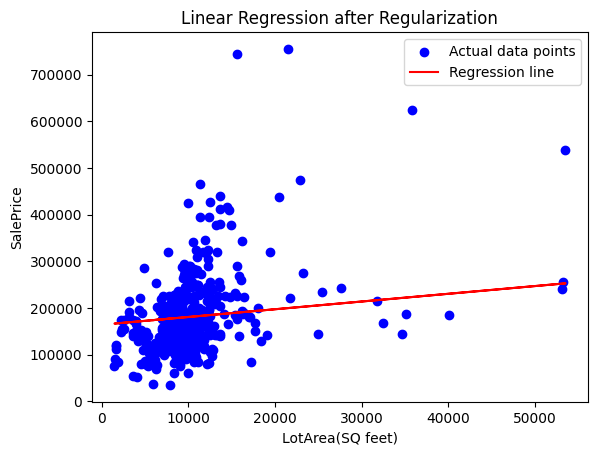

      LotArea  Actual_SalePrice  Predicted_SalePrice
107      6000            115000        173853.011314
835      9600            128000        179819.153539
1188     8935            195000        178717.074489
804      9000            118000        178824.796501
1159     9120            185000        179023.667909
942      7711            150000        176688.586133
370      8121            172400        177368.063441
537     12735            111250        185014.669060
23       4224            129900        170909.714483
275      7264            205000        175947.790140
261      9588            276000        179799.266398
762      8640            215200        178228.182279
24       8246            154000        177575.221158
222     11475            179900        182926.519281
1129     7200            140000        175841.725389
503     15602            289000        189766.038438
997     11717            185000        183327.576620
1401     7415            193000        176198.

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)

# making predictions
y_pred = ridge.predict(X_test)

# evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Model Coefficients: {ridge.coef_}n")

# Create a DataFrame with YrSold, actual, and predicted prices
results_df = X_test.copy()
results_df['Actual_SalePrice'] = y_test.values
results_df['Predicted_SalePrice'] = y_pred

#plotting
plt.scatter(X_test, y_test, color='blue', label='Actual data points')
plt.plot(X_test, y_pred, color='red', label='Regression line')
plt.xlabel('LotArea(SQ feet)')
plt.ylabel('SalePrice')
plt.title('Linear Regression after Regularization')
plt.legend()
plt.show()

print(results_df.head(20))

# **PCA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/ML_LAB/house_price_train.csv")
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
df = df.select_dtypes(include=['float64', 'int64'])
df.fillna(df.median())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [ ]:
std = StandardScaler()
scaled_data = std.fit_transform(df.fillna(df.median()))


In [ ]:
pca = PCA()
pca_data = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(len(df.columns))])

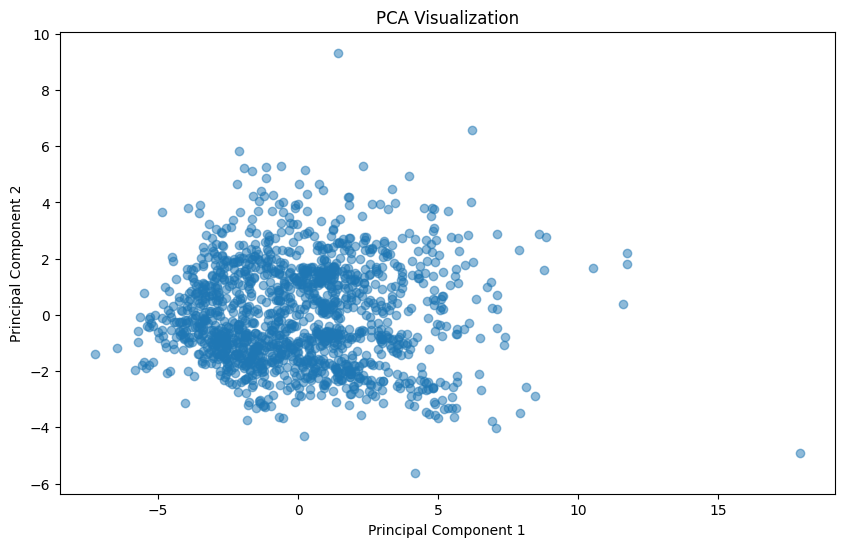

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization")
plt.show()

In [ ]:
#Most Variable for PC1 and PC2

loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(len(df.columns))], index=df.columns)

# Absolute values of loadings show importance
pc1_important = loadings["PC1"]
pc2_important = loadings["PC2"]

print("\nMost important variables for PC1:")
print(pc1_important)

print("\nMost important variables for PC2:")
print(pc2_important)


Most important variables for PC1:
Id              -0.002994
MSSubClass      -0.017919
LotFrontage      0.151316
LotArea          0.102548
OverallQual      0.290450
OverallCond     -0.073516
YearBuilt        0.224235
YearRemodAdd     0.199228
MasVnrArea       0.186009
BsmtFinSF1       0.136997
BsmtFinSF2      -0.010574
BsmtUnfSF        0.107687
TotalBsmtSF      0.247004
1stFlrSF         0.244870
2ndFlrSF         0.126701
LowQualFinSF    -0.010346
GrLivArea        0.284443
BsmtFullBath     0.074133
BsmtHalfBath    -0.011541
FullBath         0.245963
HalfBath         0.119029
BedroomAbvGr     0.102403
KitchenAbvGr    -0.021280
TotRmsAbvGrd     0.226665
Fireplaces       0.176469
GarageYrBlt      0.206154
GarageCars       0.268064
GarageArea       0.263894
WoodDeckSF       0.127798
OpenPorchSF      0.140468
EnclosedPorch   -0.068852
3SsnPorch        0.016164
ScreenPorch      0.031251
PoolArea         0.046614
MiscVal         -0.010221
MoSold           0.020528
YrSold          -0.012493
Sal

In [ ]:
explained_variance = pca.explained_variance_ratio_
print(f"\nVariance explained by PC1: {explained_variance[0]:.2f}")
print(f"Variance explained by PC2: {explained_variance[1]:.2f}")
print(f"Combined variance by PC1 and PC2: {explained_variance[0] + explained_variance[1]:.2f}")


Variance explained by PC1: 0.21
Variance explained by PC2: 0.08
Combined variance by PC1 and PC2: 0.29


In [ ]:
cumulative_variance = np.cumsum(explained_variance)
num_components_80 = np.argmax(cumulative_variance >= 0.80)

print(f"\nNumber of Principal Components needed to explain >80% variance: {num_components_80}")


Number of Principal Components needed to explain >80% variance: 17
